# Job_title_to_function_mapping Challenge (ExelThread)

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import re
import argparse
import nltk
import sys
from itertools import chain
import inflect
import pickle
import os
import csv
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read in a file, create a list of string
def readfile(filelocation):
    with open(filelocation,encoding='utf-8',errors='ignore') as f:
        l = f.readlines()
        l= [re.sub("[\(\[].*?[\)\]]", "", x) for x in l]
        return [i.strip() for i in l]
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#Remove Punctuations that definitely won't contribute
def remove_punctuation(s):
    # Directly removable
    for char in ['"','//',',']:
        s = s.replace(char, "")
    s = s.strip()
    #remove those consists of only punctuation and number
    s = filter(lambda x: not re.match("[0-9~!@#$%^*()_\+{}\":;\']+", x), s.split())
    return ' '.join(s)

# transform the abbrevations like {CEO, CFO, etc.}
def transform(jobtitle_list):
    clean_titles=[]
    for title in jobtitle_list:
        words=title.split()
        clean_title=[remove_punctuation(s) for s in words]
        clean_title = [transforms[word] if word in transforms else word for word in clean_title]
        clean_title = [i.split() for i in clean_title]
        clean_title = list(chain.from_iterable(clean_title))
        clean_title = ' '.join(clean_title)
        clean_titles.append(str(clean_title))
    return(clean_titles)

#Word Count
def wordCount(jobtitle_list):
    wordcount = {}
    for jobtitle in jobtitle_list:
        for word in jobtitle.split():
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
    return wordcount

#Sort Word Count: return a sorted word count list
def sortWordCount(wordCountDict):
    return sorted(wordCountDict, key = wordCountDict.get, reverse=True)

#High Frequency words
def getHighFrequencyWords(wordCountDict, sortedWordCountList, percentage=0.6):
    count = 0;
    total = sum(wordCountDict.values())
    expected_count = total * percentage
    index = 0
    for word in sortedWordCountList:
        count += wordCountDict[word]
        if count > expected_count:
            index = sortedWordCountList.index(word)
            break
    result = [s for s in sortedWordCountList[0:index] if s != len(s) * s[0]]
    result = [s for s in result if "NN" in nltk.pos_tag([s])[0][1]]
    result = [s for s in result if s != "Sr"]
    return result

#Remove duplicates
def unique_list(l):
    ulist = []
    p = inflect.engine()
    [ulist.append(x) for x in l if x not in ulist]
    ulist = [p.singular_noun(x) if p.singular_noun(x) else x for x in ulist]
    return ulist

if __name__=="__main__":
    table = str.maketrans('', '', string.punctuation)
    inputfile="titles.txt"
    jobtitle_list = readfile(inputfile)
    transforms = load_obj('abbv_transforms')
    clean_jobtitle_list=transform(jobtitle_list)
        
    wordCountDict = wordCount(clean_jobtitle_list)
    sortedWordList = sortWordCount(wordCountDict)
    
    HighFrequencyList = getHighFrequencyWords(wordCountDict, sortedWordList, 0.9)
    
    print("Total Job_Titles:"+str(len(jobtitle_list))+"\n")
    print("First 10 Job_Titles:\n")
    for i in range(0,10):
        print(clean_jobtitle_list[i])
        
    print("\n"+"Top 10 High Frequency words:\n")
    for key in sortedWordList[0:10]: 
        print("{} : {}".format(key, wordCountDict[key]))
        
    print("\n"+"Filtered_HF_List_top_10:"+ str(HighFrequencyList[:10]))   

Total Job_Titles:22290

First 10 Job_Titles:

Founder and Chief Executive Officer
Geo Team
Director Customer Success EMEA
Vice President Business Development
Managing Partner
Managing Partner
Chief Executive Officer or President
Vice President Business Development
Senior Category Manager
Senior Manager Product Development

Top 10 High Frequency words:

President : 7199
Vice : 6346
and : 5528
Chief : 3924
Officer : 3864
Director : 3513
Senior : 3223
of : 3084
Marketing : 2968
Executive : 2849

Filtered_HF_List_top_10:['President', 'Vice', 'Chief', 'Officer', 'Director', 'Marketing', 'Executive', 'Development', 'Business', 'Manager']


## Text analysis

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from random import shuffle
from wordcloud import WordCloud
from nltk import bigrams, FreqDist
from nltk.tokenize import RegexpTokenizer
from operator import itemgetter
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
stopset = list(set(stopwords.words('english')))
from collections import Counter
from nltk import word_tokenize
from nltk.util import ngrams

WNL = nltk.WordNetLemmatizer()

#raw_text

rawText=" ".join(clean_jobtitle_list)
rawText=re.sub("[^a-z0-9]+"," ", rawText, flags=re.IGNORECASE)
#Lowercase and tokenize
rawText = rawText.lower() 
#Remove quote
rawText = rawText.replace("'", "")
#tokenize 
tokens = nltk.word_tokenize(rawText)
text = nltk.Text(tokens)
# Remove extra chars and remove stop words.
text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text]
text_content = [word for word in text_content if word not in stopset]
# Remove any entries where the len is zero ex:[].
text_content = [s for s in text_content if len(s) != 0]
#get the lemmas of each word to reduce the number of similar words on the word cloud.
text_content = [WNL.lemmatize(t) for t in text_content]

### WordCloud Analysis

In [4]:
# Set word cloud params 
WC_height = 500
WC_width = 1000
WC_max_words = 100

#wordcloud model
wordCloud = WordCloud(collocations=False,max_words=WC_max_words, height=WC_height, width=WC_width)

def ngram_wordcloud(token_list,n=3):
    
    n_gram_dict=dict(Counter(ngrams(token_list,n)))
    scoredList = sorted(n_gram_dict, key=itemgetter(1), reverse=True)
    listLen = len(scoredList)
    word_dict = {}
    for i in range(0,len(scoredList)):
        new_key=str('_'.join(scoredList[i]))
        old_key=scoredList[i]
        word_dict[new_key] = n_gram_dict[old_key]
        
    wordCloud.generate_from_frequencies(word_dict) 
    plt.title('Most frequently occurring '+str(n)+'_gram connected with an underscore(_)')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.show()
    file_name="WordCloud_"+str(n)+"grams_frequent_words.png"
    wordCloud.to_file(file_name)
    
    #return the dict
    return word_dict

#### Unigrams

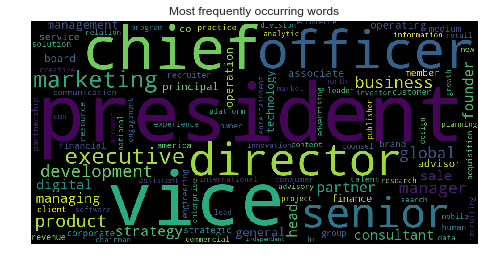


Top 10 Unigrams:


,Unigram,Count
0,president,7327
1,vice,6396
2,chief,3964
3,officer,3897
4,director,3726
5,senior,3241
6,marketing,3026
7,executive,2873
8,product,1539
9,development,1525


In [5]:
wordCloud.generate(" ".join(text_content))
plt.title('Most frequently occurring words')
plt.imshow(wordCloud)
plt.axis("off")
plt.show()
wordCloud.to_file("WordCloud_for_frequent_words.png")
fdist = FreqDist(text_content)
print("\n"+"Top 10 Unigrams:")
pd.DataFrame(fdist.most_common(10),columns=['Unigram','Count'])

#### Bigrams

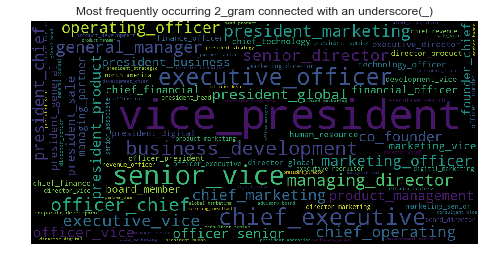


Top 10 Bigrams:


,Bigrams,Count
5234,vice_president,6374
393,senior_vice,1756
11839,chief_executive,1284
6602,executive_officer,1281
13599,business_development,870
15578,officer_chief,765
13057,managing_director,649
8265,general_manager,639
7743,president_marketing,636
390,executive_vice,601


In [6]:
bigrams= ngram_wordcloud(text_content,2)
bigrams  = pd.DataFrame.from_dict(bigrams,orient='index').reset_index()
bigrams.columns=['Bigrams','Count']
print('\n'+'Top 10 Bigrams:')
bigrams.sort_values('Count',ascending=False).head(10)

#### Trigrams

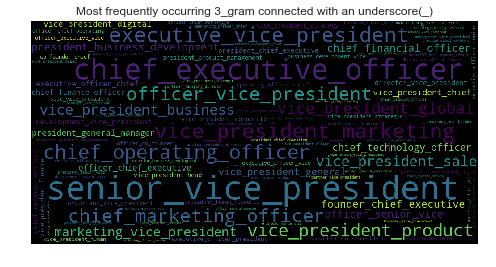


Top 10 Trigrams:


,Trigrams,Count
546,senior_vice_president,1755
25341,chief_executive_officer,1280
9831,vice_president_marketing,632
543,executive_vice_president,601
13446,chief_operating_officer,536
549,officer_vice_president,470
16182,chief_marketing_officer,464
9830,vice_president_product,452
9875,vice_president_global,447
9827,vice_president_business,367


In [7]:
trigrams  = ngram_wordcloud(text_content,3) 
trigrams  = pd.DataFrame.from_dict(trigrams,orient='index').reset_index()
trigrams.columns=['Trigrams','Count']
print('\n'+'Top 10 Trigrams:')
trigrams.sort_values('Count',ascending=False).head(10)

#### Fourgrams

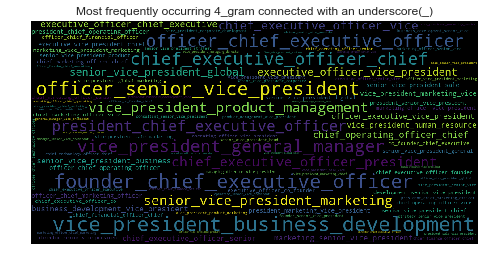


Top 10 Fourgrams:


,Fourgrams,Count
14626,vice_president_business_development,289
49855,founder_chief_executive_officer,262
7967,officer_senior_vice_president,253
49871,officer_chief_executive_officer,217
14628,vice_president_general_manager,217
37539,chief_executive_officer_chief,212
49868,president_chief_executive_officer,160
14762,vice_president_product_management,150
619,senior_vice_president_marketing,135
37528,chief_executive_officer_president,132


In [8]:
fourgrams = ngram_wordcloud(text_content,4)
fourgrams = pd.DataFrame.from_dict(fourgrams,orient='index').reset_index()
fourgrams.columns=['Fourgrams','Count']
print('\n'+'Top 10 Fourgrams:')
fourgrams.sort_values('Count',ascending=False).head(10)

#### Fivegrams

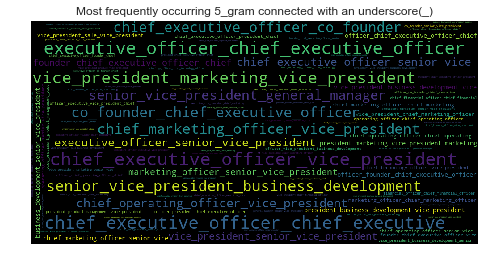


Top 10 Fivegrams:


,Fivegrams,Count
46287,chief_executive_officer_vice_president,130
27327,executive_officer_chief_executive_officer,124
46284,chief_executive_officer_chief_executive,124
18536,vice_president_marketing_vice_president,102
594,senior_vice_president_business_development,85
44472,co_founder_chief_executive_officer,81
32003,chief_marketing_officer_vice_president,80
46277,chief_executive_officer_co_founder,75
626,senior_vice_president_general_manager,74
26941,chief_operating_officer_vice_president,60


In [9]:
fivegrams = ngram_wordcloud(text_content,5)
fivegrams = pd.DataFrame.from_dict(fivegrams,orient='index').reset_index()
fivegrams.columns=['Fivegrams','Count']
print('\n'+'Top 10 Fivegrams:')
fivegrams.sort_values('Count',ascending=False).head(10)

In [10]:
#Load saved lookups created using lookups.py
level_dict=load_obj('Job_Levels')
func_dict=load_obj('Job_Functions')

df=pd.DataFrame(clean_jobtitle_list)
df.columns=["Job Title"]
df["Job Function"]=np.nan
df["Job Level"]=np.nan

- Job Levels and Categories can have multiple values if required
- For now assigning multiple values for Job_Function and single value for Job_Level

In [11]:
for i in range(0,int(len(df))):
    level=[]
    categories=[]
    for key in level_dict:
        if key in df.loc[i,"Job Title"].lower():
            level=level_dict[key]
            #print(levels)
    for key in func_dict:
        if key in df.loc[i,"Job Title"].lower():
            categories.append(func_dict[key])
    df.loc[i,"Job Level"]= str(level) if level!=[] else 'Other'
    df.loc[i,"Job Function"]=",".join(set(categories)) if categories!=[] else 'Other'

## First 20 Job_Titles with Job_Func and Job_Level

In [12]:
df.head(20)

,Job Title,Job Function,Job Level
0,Founder and Chief Executive Officer,Management,Executive
1,Geo Team,Other,Other
2,Director Customer Success EMEA,Customer Services,Manager
3,Vice President Business Development,"Management,Business",Executive
4,Managing Partner,Management,Executive
5,Managing Partner,Management,Executive
6,Chief Executive Officer or President,Management,Executive
7,Vice President Business Development,"Management,Business",Executive
8,Senior Category Manager,Management,Manager
9,Senior Manager Product Development,"Management,Products",Manager


## 'Job_Level' Analysis

In [13]:
#print sample record from each category
df.groupby('Job Level').tail(1).reset_index(drop=True)

,Job Title,Job Function,Job Level
0,Senior Software Engineer,"Engineering,IT",Associate
1,Coordinator of Student Affairs,Education,Student
2,Adjunct Professor,Education,Professor
3,Marketing Email and CRM Analyst,Marketing,Analyst
4,Project Coordinator,Other,Other
5,Associate,Consultant Services,Contributor
6,Consultant,Consultant Services,Consultant
7,Managing Director,Management,Manager
8,Vice President/GM Litigation Software,"Management,IT",Executive


In [14]:
#Job Level counts
df.groupby('Job Level')['Job Title'].size().reset_index(name='counts')

,Job Level,counts
0,Analyst,64
1,Associate,92
2,Consultant,1891
3,Contributor,390
4,Executive,12671
5,Manager,4225
6,Other,2902
7,Professor,50
8,Student,5


## 'Job Function' Analysis

In [15]:
jf_df= df.groupby('Job Function')['Job Title'].size().sort_values(ascending=False).reset_index(name='counts')
print('\n'+'Distinct job_functions:'+str(len(jf_df))) 
jf_df.head(10)


Distinct job_functions:454


,Job Function,counts
0,Management,7339
1,Other,3203
2,"Management,Marketing",1515
3,Consultant Services,832
4,"Management,Products",765
5,"Management,Operations",723
6,"Management,Finances",549
7,Marketing,541
8,"Management,Business",525
9,"Management,Strategy",496


These can be reduced as per requirement(update the lookups and merge multiple values to major category)

In [ ]:
#Saving output to the csv_file
df.to_csv('Job_titles_with_func_&_level.csv',index=False)

In [16]:
#----------Below functions required for future work-------------------------------
#Filter Words
def filterWordsFormRawJobTitle(jobtitle_list, high_frequency_list):
    jobtitle_list =  [" ".join(filter(lambda x: x in high_frequency_list, title.split())) for title in jobtitle_list]
    jobtitle_list =  [jobtitle for jobtitle in jobtitle_list if len(jobtitle.split()) >= 2]
    return jobtitle_list

#String normalization 
def stringNormalization(jobtitle_list):
    #Change To Camel Case
    jobtitle_list = [' '.join(word[0].upper() + word[1:] for word in job.split()) for job in jobtitle_list]
    #Remove Duplicate Words
    jobtitle_list = [" ".join(unique_list(job.split())) for job in jobtitle_list]
    #Aggregate to Set
    return list(set(jobtitle_list))
#------------------------------------------------------------------------------------


### Unsupervised Learning: As only the job titles are available, I am trying to cluster the titles based on string similarity

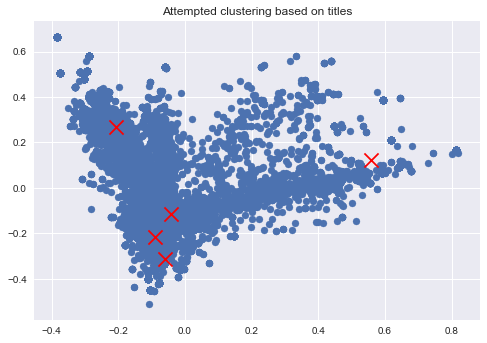

In [17]:
from nltk.metrics.distance import jaccard_distance
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(clean_jobtitle_list).todense()

pca = PCA(n_components=5).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

kmeans = KMeans(n_clusters=5).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Attempted clustering based on titles')
plt.show()

## NOTE:
- Currently mapping cleaned titles, need to create inverted index for original title mapping
- I am working on using n-gram model(bigrams,trigrams) to remove redundant words and find more suitable job_functions .
- Also, as the dataset is unlabelled, I am working on unsupervised learning based clustering/topic modeling for better job_function , job_level assignment
- The work is incomplete for now, code snippets can be found in future_work notebook